# Описание проекта



Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [25]:
pip install sweetviz

Note: you may need to restart the kernel to use updated packages.


### Импорт библиотек

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression         # импорт модели линейной регрессии
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats as st
import matplotlib.pyplot as plt                           # импорт библиотеки для работы с графиками
from sklearn.preprocessing import StandardScaler
import sweetviz as sv

### Чтение файлов 

In [27]:
data_0 = pd.read_csv('...') #
data_1 = pd.read_csv('...') #   чтение трёх датафреймов и запись их под тремя переменными
data_2 = pd.read_csv('...') #

### Поиск пропусков, неверных типов данных, дубликов

In [28]:
data_0.info() #
data_1.info() #    вывод информации о трёх датафреймах
data_2.info() #

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

**Вывод**

Пропусков в датафреймах нет, все данные имеют нужный тип данных.

In [29]:
display(data_0.head())        #
display(data_1.head())        # вывод первых 5 строк 3 датафремов
data_2.head()                 #

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


**Вывод**

Как видно из датафреймов, столбец id - всего лишь символьное обозначение скважины и для прогнозирования добычи не интересно.

In [30]:
print(data_0.duplicated().unique())  #
print(data_1.duplicated().unique())  #  поиск дубликатов в 3 датафреймах
print(data_2.duplicated().unique())  #

[False]
[False]
[False]


**Вывод**

Дубликаты отсутствуют.

### Обоснование масштабирования

In [31]:
print(data_0[['f0','f1','f2']].max()-data_0[['f0','f1','f2']].min())
print()
print(data_1[['f0','f1','f2']].max()-data_1[['f0','f1','f2']].min())
data_2[['f0','f1','f2']].max()-data_2[['f0','f1','f2']].min()

f0     3.770936
f1     2.191988
f2    28.092118
dtype: float64

f0    61.031331
f1    45.092661
f2     5.037865
dtype: float64


f0    15.998266
f1    14.928821
f2    28.709737
dtype: float64

**Вывод**

В 2 из 3 датафреймов размах признаков отличается на порядок. Есть необходимость масштабирования при использовании некоторых моделей. В нашем случае будет использоваться простая модель линейной регресии, которая должна быть нечувствительна к разным масштабам, мы это и проверим.

**Вывод по разделу**

Как и заявлялость, в каждом датафрейме информация о 10000 потенциальных скважин. Предоставленные данные не содержат ошибок. Некоторые признаки в датафрейме различаются на порядок, это необходимо иметь ввиду.

In [32]:

report_0 = sv.analyze([data_0, "Регион 0"])
report_1 = sv.analyze([data_1, "Регион 1"])
report_2 = sv.analyze([data_2, "Регион 2"])

                                             |                                             | [  0%]   00:00 ->…

                                             |                                             | [  0%]   00:00 ->…

                                             |                                             | [  0%]   00:00 ->…

In [33]:
report_0.show_html('common analysis_0.html')
report_1.show_html('common analysis_1.html')
report_2.show_html('common analysis_2.html')

Report common analysis_0.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Report common analysis_1.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Report common analysis_2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**Вывод**

В данных встречаются повторяющиеся id скважин с разными значениями потенциальных запасов нефти, необходимо уточнить у источника датафреймов, почему так получилось.

## Обучение и проверка модели

### Модель для региона 0

In [34]:
features_0 = data_0.drop(['id', 'product'], axis=1)               # извлечение признаков (id - не нужный нам признак)
target_0 = data_0['product']                                      # извлечение целевого признака
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(   # разбиение признаков на выборки (обу
    features_0, target_0, test_size=0.25, random_state=12345)                            # обучающую и валидационную в соотно
                                                                                         # шении 25:75
numeric = ['f0','f1','f2']                                        # выделяем названия числовых признаков для масштабирования

scaler = StandardScaler()                                         # определяем метод масштабирования под новой переменной
scaler.fit(features_train_0[numeric])                             # определяем параметры масштабирования (среднее, дисперсию)

features_train_0_scaled = scaler.transform(features_train_0[numeric])           # выполняем масштабирование на тестовой выборке
features_valid_0_scaled = scaler.transform(features_valid_0[numeric])           # выполняем масштабирование на валид. выборке



model = LinearRegression()                                       # определяем метод МО (линейная регрессия) под новой переменной
model.fit(features_train_0_scaled, target_train_0)               # обучаем модель на обучающей выборке с масштабированием
predictions_valid_0 = pd.Series(model.predict(features_valid_0_scaled))# получаем предсказания модели на валидационной выборке с мас
# штабированием
result = mean_squared_error(target_valid_0, predictions_valid_0) ** 0.5   # вычисляем среднеквадратичное отклонение 
print("РЕГИОН 0")
print("Результаты при масштабировании")
print("Cредний запас предсказанного сырья:", predictions_valid_0.mean())
print(f"RMSE модели линейной регрессии на валидационной выборке: {result} тыс. баррелей", )
print("R2 модели линейной регрессии на валидационной выборке:", r2_score(target_valid_0, predictions_valid_0))

model.fit(features_train_0, target_train_0)                     # обучаем модель на обучающей выборке
predictions_valid_0 = pd.Series(model.predict(features_valid_0))           # получаем предсказания модели на валидационной выборке
result = mean_squared_error(target_valid_0, predictions_valid_0) ** 0.5
print()
print("Результаты без масштабирования")
print("Cредний запас предсказанного сырья:", predictions_valid_0.mean())
print(f"RMSE модели линейной регрессии на валидационной выборке: {result} тыс. баррелей", )
print("R2 модели линейной регрессии на валидационной выборке:", r2_score(target_valid_0, predictions_valid_0))

РЕГИОН 0
Результаты при масштабировании
Cредний запас предсказанного сырья: 92.59256778438008
RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813 тыс. баррелей
R2 модели линейной регрессии на валидационной выборке: 0.27994321524487786

Результаты без масштабирования
Cредний запас предсказанного сырья: 92.59256778438008
RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813 тыс. баррелей
R2 модели линейной регрессии на валидационной выборке: 0.27994321524487786


**Вывод**

В нашем случае масштабирование не влияет на предсказания модели линейной регрессии.

Что же касается самих результатов, то среднеквадратичное отклонение существенно, но согласно метрике R2 наша модель научилась предсказывать результаты лучше, чем простая модель заполнения средним значением.   

### Модель для региона 1

In [37]:
# Комментарии -- см. подраздел "Модель для региона 0"
features_1 = data_1.drop(['id', 'product'], axis=1)                                  
target_1 = data_1['product']                                                       
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

model = LinearRegression()
model.fit(features_train_1, target_train_1)
predictions_valid_1 = pd.Series(model.predict(features_valid_1))
result = mean_squared_error(target_valid_1, predictions_valid_1) ** 0.5
print("РЕГИОН 1")
print("Cредний запас предсказанного сырья:", predictions_valid_1.mean())
print(f"RMSE модели линейной регрессии на валидационной выборке: {result} тыс. баррелей", )
print("R2 модели линейной регрессии на валидационной выборке:", r2_score(target_valid_1, predictions_valid_1))

РЕГИОН 1
Cредний запас предсказанного сырья: 68.72854689544577
RMSE модели линейной регрессии на валидационной выборке: 0.8930992867756166 тыс. баррелей
R2 модели линейной регрессии на валидационной выборке: 0.9996233978805127


**Вывод**

Регион 1 оказался легко прогнозируемым, но менее богатым по нефти. Величина R2 говорит, что среднеквадратичное отклонениие крайне мало, по сравнению со средним запасом предсказанного сырья. 

In [38]:
# Комментарии -- см. подраздел "Модель для региона 0"
features_2 = data_2.drop(['id', 'product'], axis=1)# извлеките признаки 
target_2 = data_2['product'] # извлеките целевой признак
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

model = LinearRegression()
model.fit(features_train_2, target_train_2)
predictions_valid_2 = model.predict(features_valid_2) # получите предсказания модели на валидационной выборке
result = mean_squared_error(target_valid_2, predictions_valid_2) ** 0.5
for i in range(0,3):
    print(f"РЕГИОН {i}")
print("Cредний запас предсказанного сырья:", predictions_valid_2.mean())
print("RMSE модели линейной регрессии на валидационной выборке:", result)
print("R2 модели линейной регрессии на валидационной выборке:", r2_score(target_valid_2, predictions_valid_2))

РЕГИОН 0
РЕГИОН 1
РЕГИОН 2
Cредний запас предсказанного сырья: 94.96504596800492
RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434
R2 модели линейной регрессии на валидационной выборке: 0.20524758386040443


In [ ]:
pd.concat([pd.Series(predictions_valid_0), pd.Series(predictions_valid_1)], axis=1)

**Вывод**

Среднеквадратичное отклонение по порядку величины совпадает со средним запасом, но R2 говорит, что модель всё-таки лучше простого заполнения средним.

## Подготовка к расчёту прибыли

Модель мы обучили и проверили на валидационной выборке, для дальнейших расчётов логично использовать всю выборку целиком. Для этого необходимо получить предсказания на обучающей выборке, а затем объединить с предсказаниями на валидационной. 

In [39]:
# Регион 0
predictions_train_0 = model.predict(features_train_0)           # строим предсказания на обучающей выборке
predictions_train_0 = pd.Series(predictions_train_0)            # приводим предсказания к типу Series
predictions_train_0.index = target_train_0.index                # индексируем предсказания согласно индексам целевого признака
predictions_valid_0 = pd.Series(predictions_valid_0)            # приводим предсказания к типу Series
predictions_valid_0.index = target_valid_0.index                # индексируем предсказания согласно индексам целевого признака
predictions_0 = pd.concat([predictions_train_0, predictions_valid_0]).sort_index() # склеиваем два Series, производим сортиров
# ку по индексам

# Регион 1
# Комментаии для региона 1 аналогичны комментариям региона 0
predictions_train_1 = model.predict(features_train_1)
predictions_train_1 = pd.Series(predictions_train_1)
predictions_train_1.index = target_train_1.index
predictions_valid_1 = pd.Series(predictions_valid_1)
predictions_valid_1.index = target_valid_1.index
predictions_1 = pd.concat([predictions_train_1, predictions_valid_1]).sort_index()

# Регион 2
# Комментаии для региона 2 аналогичны комментариям региона 0
predictions_train_2 = model.predict(features_train_2)
predictions_train_2 = pd.Series(predictions_train_2)
predictions_train_2.index = target_train_2.index
predictions_valid_2 = pd.Series(predictions_valid_2)
predictions_valid_2.index = target_valid_2.index
predictions_2 = pd.concat([predictions_train_2, predictions_valid_2]).sort_index()

In [40]:
Expenses = 10 ** 10 / 200                             # расходы на скважину = бюждет / кол-во скважин
Oil_enough = round(Expenses / 450000 , 6)             # граница безубыточности соотв. доходы = расходы
print(f"Расходы на скважину: {Expenses} рублей" )
print(f"Достаточный объём сырья c одной скважины: {Oil_enough} тыс. баррелей")

Расходы на скважину: 50000000.0 рублей
Достаточный объём сырья c одной скважины: 111.111111 тыс. баррелей


Cредний запас предсказанного сырья в регионе 0: 94.46306345376044


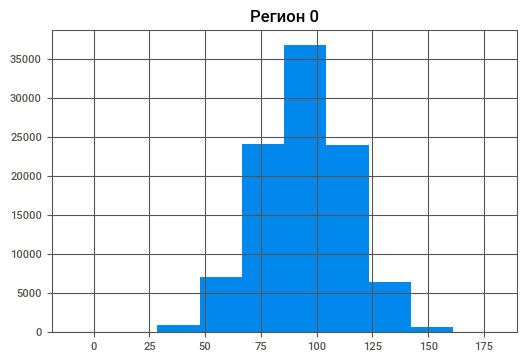

Cредний запас предсказанного сырья в регионе 1: 88.62677963817423


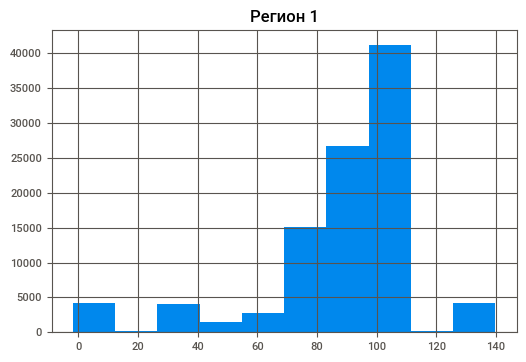

Cредний запас предсказанного сырья в регионе 2: 95.02020328978843


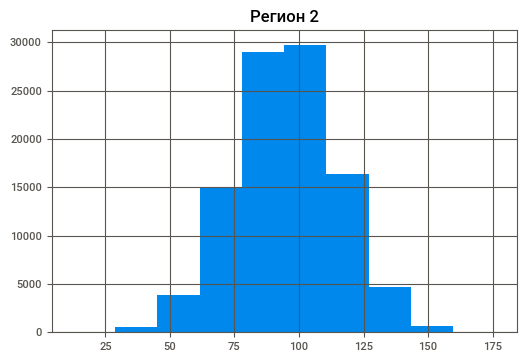

In [41]:
print("Cредний запас предсказанного сырья в регионе 0:", predictions_0.mean())
predictions_0.hist()
plt.title('Регион 0')
plt.show()
print("Cредний запас предсказанного сырья в регионе 1:", predictions_1.mean())
predictions_1.hist()
plt.title('Регион 1')
plt.show()
print("Cредний запас предсказанного сырья в регионе 2:", predictions_2.mean())
predictions_2.hist()
plt.title('Регион 2')
plt.show()

**Вывод**

Средние запасы сырья меньше чем заветные 111 тыс. баррелей во всех трёх регионах, но на помощь нам должна прийти функция отбора 200 наиболее богатых скважин. Построенные распределения по кол-ву запасов указывают на то, что во втором регионе возможны проблемы с окупаемостью - распределение сильно скошено влево, в сторону небольших объёмов добычи.

### Функция для расчёта прибыли по выбранным скважинам и предсказаниям

In [42]:
def calculation(predictions, targets):   
    predictions_sorted = predictions.sort_values(ascending=False).head(200)   # сортируем поданные на вход предсказания,
# выбираем первые 200 скважин по кол-ву запасов нефти
    sum_extraction = sum(targets[predictions_sorted.index])             # считаем реальные суммарные запасы нефти 
# в этих скважинах (для этого следим, чтобы индексы предсказаний совпадали с индексами целевого признака)
    profit = round(sum_extraction * 450000 - 10 ** 10 , 2)    # считаем и округляем прибыль
    return profit        # подаём прибыль на выход функции

## Расчёт прибыли и рисков 

### Регион 0 

Нижняя граница 95% доверительного интервала: -182771754.63
Верхняя граница 95% доверительного интервала: 928832198.61
Риски убытков в регионе значителен и составляет: 9.6%
Средняя прибыль составляет: 361876808.49 руб


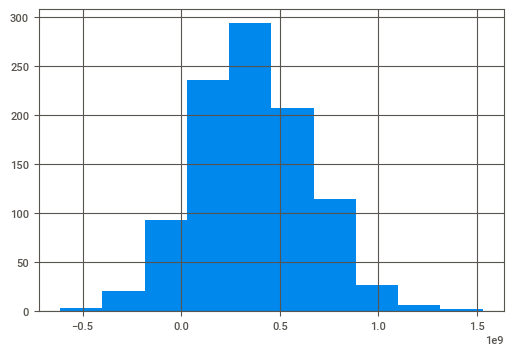

In [43]:
state = np.random.RandomState(12345)
values = []
for i in range(1000):
    target_subsample = target_0.sample(frac=500/len(target_0), replace=True, random_state=state) # организуем Bootstrap
    pred_subsample = predictions_0[target_subsample.index] # выбираем случайным образом 500 скажин, берём соотв. предсказания
    values.append(calculation(pred_subsample, target_subsample))# вызываем функцию подсчёта прибыли, записываем 
# получившуюся прибыль
values = pd.Series(values)                                 # переводим наше распределение в тип Series 
lower = values.quantile(0.025)                             # нижняя граница доверительного интервала 
upper = values.quantile(0.975)                             # верхняя граница доверительного интервала
print(f'Нижняя граница 95% доверительного интервала: {round(lower,2)}')
print(f'Верхняя граница 95% доверительного интервала: {round(upper,2)}')

values.hist()

alpha = .025                                       # Критическая погрешность в 2,5%
p_value = len(values[values < 0])/len(values)      # Доля убыточных предсказаний
if (p_value < alpha) and (values.mean() > 0):
    print(f'Риски убытков в регионе приемлемы и составляют: {p_value * 100}%')
else:
    print(f'Риски убытков в регионе значителен и составляет: {p_value * 100}%')
print(f'Средняя прибыль составляет: {round(values.mean(),2)} руб')

### Регион 1

Нижняя граница 95% доверительного интервала: 47919656.58
Верхняя граница 95% доверительного интервала: 877499046.25
Риски убытков в регионе приемлемы и составляют: 1.8%
Средняя прибыль составляет: 467524955.79 руб


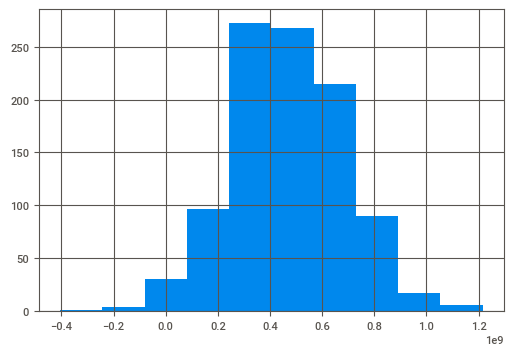

In [44]:
state = np.random.RandomState(12345)
values = []
for i in range(1000):
    target_subsample = target_1.sample(frac=500/len(target_1), replace=True, random_state=state)  # организуем Bootstrap
    pred_subsample = predictions_1[target_subsample.index] # выбираем случайным образом 500 скажин, берём соотв. предсказания
    values.append(calculation(pred_subsample, target_subsample))# вызываем функцию подсчёта прибыли, записываем 
# получившуюся прибыль
values = pd.Series(values)                                 # переводим наше распределение в тип Series 
lower = values.quantile(0.025)                             # нижняя граница доверительного интервала
upper = values.quantile(0.975)                             # верхняя граница доверительного интервала
print(f'Нижняя граница 95% доверительного интервала: {round(lower,2)}')
print(f'Верхняя граница 95% доверительного интервала: {round(upper,2)}')
values.hist()

alpha = .025                                       # Критическая погрешность в 2,5%
p_value = len(values[values < 0])/len(values)      # Доля убыточных предсказаний
if (p_value < alpha) and (values.mean() > 0):
    print(f'Риски убытков в регионе приемлемы и составляют: {round(p_value * 100,2)}%')
else:
    print(f'Риски убытков в регионе значителен и составляет: {round(p_value * 100,2)} %')
print(f'Средняя прибыль составляет: {round(values.mean(),2)} руб')

### Регион 2 

Нижняя граница 95% доверительного интервала: -158184644.99
Верхняя граница 95% доверительного интервала: 971736212.73
Риски убытков в регионе значителен и составляет: 7.9%
Средняя прибыль составляет: 424457434.73 руб


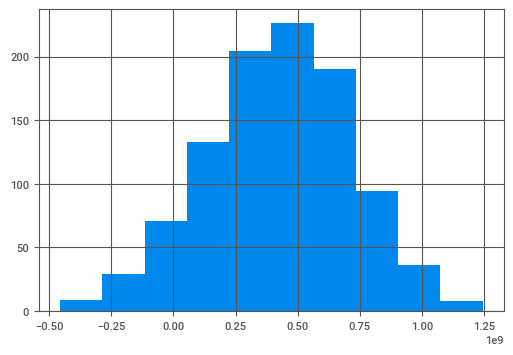

In [45]:
state = np.random.RandomState(12345)
values = []
for i in range(1000):        # создаём цикл для 1000 выборок
    target_subsample = target_2.sample(frac=500/len(target_2), replace=True, random_state=state) # организуем Bootstrap
    pred_subsample = predictions_2[target_subsample.index] # выбираем случайным образом 500 скажин, берём соотв. предсказания
    values.append(calculation(pred_subsample, target_subsample))# вызываем функцию подсчёта прибыли, записываем получившуюся 
# прибыль
values = pd.Series(values)                                                # переводим наше распределение в тип Series 
lower = values.quantile(0.025)                                            # нижняя граница доверительного интервала
upper = values.quantile(0.975)                                            # верхняя граница доверительного интервала
print(f'Нижняя граница 95% доверительного интервала: {round(lower,2)}')
print(f'Верхняя граница 95% доверительного интервала: {round(upper,2)}')
values.hist()

alpha = .025                                           # Критическая погрешность в 2,5%                                     
p_value = (values < 0).mean()          # Доля убыточных предсказаний
if (p_value < alpha) and (values.mean() > 0):
    print(f'Риски убытков в регионе приемлемы и составляют: {p_value * 100}%')
else:
    print(f'Риски убытков в регионе значителен и составляет: {p_value * 100}%')
print(f'Средняя прибыль составляет: {round(values.mean(),2)} руб')

0      False
1      False
2      False
3      False
4       True
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool

**Вывод**

Регион 0 и 2 с большой долей вероятности окажется убыточными (9.6% и 7.9% соответственно). Регион 1 с достаточной долей вероятности окажется прибыльным (98.2%), кроме того он обладает наибольшей средней прибылью.

## Общий вывод

В ходе анализа трёх потенциальных регионов для разработки месторождений в качестве признаков использовались "f0", "f1" и "f2", которые имели разный масштаб в регионах. Для того, чтобы убедиться в отсутствии разного масштаба на работу модели линейной регрессии признаки были отмасштабированны и сохранены под другими переменными.

После разделения выборки на валидационную и обучающую, после обучения модели и её проверки на валидационной выборке, результаты с масштабированием и без масштабирования получились одинкаовыми.

Что же касается самого качества предсказаний, то 0 и 2 регионы оказались не так предсказуемы как 1 регион, величина R2: 
- в регионе 0: 0.27994321524487786
- в регионе 1: 0.9996233978805127
- в регионе 2: 0.20524758386040443

В то же время, регионы 0 и 2 оказались богаче по количеству нефти:
 - средний запас в регионе 0: 92.59256778438035
 - средний запас в регионе 1: 68.728546895446
 - средний запас в регионе 2: 94.96504596800492
 
Безубыточной скважиной оказалась скважина, которая приносит более 111.11 тыс. баррелей нефти. Как видно, средние запасы в регионе меньше этой цифры, но это не проблема, ведь надо выбрать 200 самых лучших, которые приносят больше 111.11 тыс. баррелей.

Для выбора 200 лучших скважин была написана специальная функция, которая в итоге, возвращает прибыль с выбранных скважин.

Поскольку у нас есть ограничение на количество иссследуемых скважин (их всего 500 из 10000), то для поиска распределения прибыли была организована методика Bootstrap на 1000 выборок. Были определены такие величины как 95% доверительный интервал:
  - в регионе 0: {-182771754.63; 928832198.61}
  - в регионе 1: {47919656.58; 877499046.25} 
  - в регионе 2: {-158184644.99; 971736212.73}

  
  Средняя прибыль:
  - в регионе 0: 361876808.49 руб
  - в регионе 1: 467524955.79 руб
  - в регионе 2: 424457434.73 руб
  
  Вероятность убытков:
  - в регионе 0: 9.6%
  - в регионе 1: 1.8%
  - в регионе 2: 7.9%
  
На основе получившихся данных к разработке рекомендуется регион 1, несмотря на тот факт, что средние запасы нефти тут ниже. Свою роль сыграло высокое качество предсказаний для региона 1.
  

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован